In [ ]:
# Connecting Google drive to Google colab environment
from google.colab import drive
drive.mount('/content/drive')
# Change working directory to folder created previously
!cd '/content/drive/My Drive/PLANT DISEASE RECOGNITION'

Mounted at /content/drive


In [ ]:
!ls


drive  sample_data


In [ ]:
%cd '/content/drive/My Drive/PLANT DISEASE RECOGNITION'

/content/drive/My Drive/PLANT DISEASE RECOGNITION


In [ ]:
!mkdir config datasets models

mkdir: cannot create directory ‘config’: File exists
mkdir: cannot create directory ‘datasets’: File exists
mkdir: cannot create directory ‘models’: File exists


In [ ]:
%cd config

/content/drive/My Drive/PLANT DISEASE RECOGNITION/config


In [ ]:
!pwd


/content/drive/My Drive/PLANT DISEASE RECOGNITION/config


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ombatsakenneth","key":"94df96c93f02f3ed7102b072cc0b12a4"}'}

In [ ]:
!ls

kaggle.json


In [ ]:
%cd '/content/drive/My Drive/PLANT DISEASE RECOGNITION/datasets'

/content/drive/My Drive/PLANT DISEASE RECOGNITION/datasets


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/PLANT DISEASE RECOGNITION/config"

In [ ]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

100% 2.69G/2.70G [00:21<00:00, 104MB/s] 
100% 2.70G/2.70G [00:22<00:00, 132MB/s]


In [ ]:
!ls


new-plant-diseases-dataset.zip


In [ ]:
#Unzipping the zip files to extract the dataset folder and deleting the zip files
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665_270deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/29050f21-a393-473e-9f9c-7fd99feef9a7___RS_HL 4533_180deg.JPG  
  inflating: new plant diseases dataset(augmented)/New

In [ ]:
!ls

'new plant diseases dataset(augmented)'   test
'New Plant Diseases Dataset(Augmented)'


In [ ]:
for (root,dirs,files) in os.walk('.', topdown = True):
  print(root, dirs)


. ['New Plant Diseases Dataset(Augmented)', 'new plant diseases dataset(augmented)', 'test']
./New Plant Diseases Dataset(Augmented) ['New Plant Diseases Dataset(Augmented)']
./New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented) ['train', 'valid']
./New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato_

In [ ]:
base_dir = './New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
os.listdir(base_dir)

['train', 'valid']

In [ ]:
len(os.listdir(os.path.join(base_dir, 'train')))

38

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import PIL
import tensorflow as tf
from tensorflow.python import keras
import warnings 
import argparse
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
# Import all neccesary Libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import PIL
import tensorflow as tf
import warnings 
import argparse
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Importing the required libraries for modelling 
from keras import Input, Model
from keras.applications import MobileNet
from keras.layers.core import Flatten, Dense,Dropout
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from sklearn.metrics import classification_report, roc_auc_score

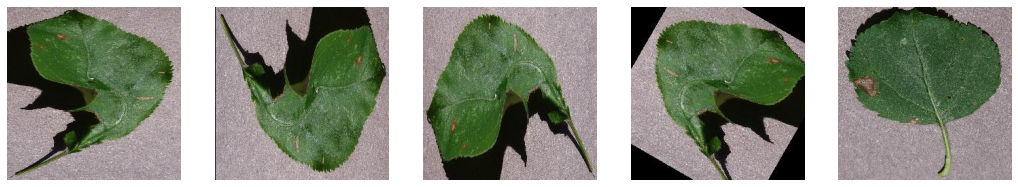

In [ ]:
fig,axes = plt.subplots(1,5, figsize=(18,18))
images = os.listdir(os.path.join(base_dir, 'train/Apple___Black_rot'))
for _ in range(5):
  ax = axes[_]
  image_path = base_dir+'/train/Apple___Black_rot/'+images[_]
  img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
  ax.imshow(img)
  ax.axis('off')
plt.show()


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')

# Data augmentation for validation dataset
validation_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
BATCH_SIZE = 32

train_set_from_dir = train_datagen.flow_from_directory(os.path.join(base_dir, 'train'),
                                                       target_size = (224,224),
                                                       batch_size = BATCH_SIZE,
                                                       class_mode = 'categorical'
                                                       )

validation_set_from_dir = validation_datagen.flow_from_directory(os.path.join(base_dir, 'valid'),
                                                                 target_size = (224,224),
                                                                 batch_size = BATCH_SIZE,
                                                                 class_mode = 'categorical'
)


Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [ ]:
classes_dict = train_set_from_dir.class_indices

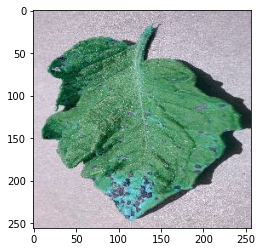

In [ ]:
img = train_set_from_dir.filepaths[np.random.random_integers(low=0, high=train_set_from_dir.samples)]
img = cv2.imread(img)
plt.imshow(img)

In [ ]:
import json
with open('/content/drive/My Drive/PLANT DISEASE RECOGNITION/class_indices.json','w') as f:
  json.dump(classes_dict, f)

In [ ]:
# Importing the required libraries for modelling 
from keras import Input, Model
from keras.applications import MobileNet
from keras.layers.core import Flatten, Dense,Dropout
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from sklearn.metrics import classification_report, roc_auc_score

In [ ]:
base_model = MobileNet(
    #Load weights into the pre-trained MobileNet model
    weights="imagenet",
    input_shape=(224, 224, 3),
    #Exclude the ImageNet classifier at the top of the model
    include_top=False
)  

In [ ]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [ ]:
head_model = base_model.output
head_model = GlobalAveragePooling2D()(head_model)
# Regularization by applying DropOut
head_model = Dropout(0.2)(head_model)
outputs = Dense(38, activation="softmax")(head_model)
mobilenet_model = Model(base_model.input, outputs, name='pretrained_mobilenet' )

for layer in mobilenet_model.layers:
    layer.trainable = False

# or if we want to set the first 20 layers of the network to be non-trainable
for layer in mobilenet_model.layers[:20]:
    layer.trainable=False
for layer in mobilenet_model.layers[20:]:
    layer.trainable=True

In [ ]:
# Compiling the model with the optimizer and loss function 

mobilenet_model.compile(optimizer = Adam(),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']
)


In [ ]:
mobilenet_model.summary()
for idx, layer in enumerate(mobilenet_model.layers):
    print(idx, layer.name, layer.trainable)

Model: "pretrained_mobilenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                       

In [ ]:
## Setting up callbacks for our model

callbacks = [
           ModelCheckpoint('content/drive/My Drive/PLANT DISEASE RECOGNITION/checkpoints/mobilenet_plantdiseases.h5', save_best_only=True, monitor='val_acc'),
           EarlyStopping(monitor='val_loss', patience=2, verbose=1),
           ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1) 
]

In [ ]:
N_EPOCHS = 10

history = mobilenet_model.fit(train_set_from_dir,
          validation_data = validation_set_from_dir,
          epochs = N_EPOCHS,
          # Use 128 random batches for training set 
          steps_per_epoch = 128, # 128 x 32 = 2**12 random samples
          # Use 64 random batches for training validation set
          validation_steps = 100, # 100 x 32 = 3200 random samples 
          callbacks = callbacks
          )

In [ ]:
n = 6
plt.figure(figsize = (8,5))
plt.plot(np.arange(1,n+1), history.history['loss'], label = 'train_loss')
plt.plot(np.arange(1,n+1), history.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(1,n+1), history.history['accuracy'], label = 'train_accuracy')
plt.plot(np.arange(1,n+1), history.history['val_accuracy'], label = 'val_accuracy')

plt.grid(True)
plt.legend(loc = "best")
plt.savefig('/content/drive/My Drive/PLANT DISEASE RECOGNITION/performance.jpg')
plt.show()

NameError: ignored

550/550 [==============================] - 648s 1s/step - loss: 0.7796 - accuracy: 0.8076


In [ ]:
print("Validation Loss :-", results[0])
print("="*30)
print("Validation Accuracy :-", results[1])

Validation Loss :- 0.7795926928520203
Validation Accuracy :- 0.8075916171073914


In [ ]:
%cd '/content/drive/My Drive/PLANT DISEASE RECOGNITION'

/content/drive/My Drive/PLANT DISEASE RECOGNITION


In [ ]:
!mkdir models

mkdir: cannot create directory ‘models’: File exists


In [ ]:
# Save model in HDF5 format
mobilenet_model.save('models/mobilenet_model.h5')

In [ ]:
# Testing on a random image from the test images directory
from PIL import Image
np.random.seed(200)
idx = np.random.randint(30)
test_images_dir = os.path.join('datasets/test', 'test')
test1 = Image.open(os.path.join(test_images_dir, os.listdir(test_images_dir)[idx]))

Text(0.5, 1.0, 'TomatoHealthy4.JPG')

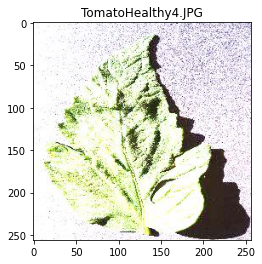

In [ ]:
plt.imshow(test1)
plt.title(os.listdir(test_images_dir)[idx])

In [ ]:
test1 = test1.resize((224,224))
test1_scaled = np.expand_dims(np.asarray(test1), axis = 0) / 255
predictions = mobilenet_model.predict(test1_scaled)
print(predictions)


1/1 [==============================] - 1s 675ms/step
[[6.6005151e-10 2.0926732e-08 4.0661048e-09 1.7891256e-06 7.1574067e-09
  2.5812776e-09 3.5235528e-10 3.1826168e-09 5.9903966e-09 3.8273912e-11
  5.8626028e-08 1.2217193e-08 9.7300394e-08 3.8779700e-07 5.2927779e-05
  1.7042485e-11 4.4307297e-12 2.5599631e-10 3.3752502e-12 1.4942617e-06
  3.6023452e-11 6.2505508e-11 8.9791683e-06 2.4153831e-06 6.5994237e-09
  9.9208307e-08 2.1692067e-08 4.0568717e-05 1.8253604e-07 1.9195768e-07
  5.4160654e-07 2.5485045e-10 9.1293401e-08 3.8053235e-04 8.8439018e-01
  8.6638154e-09 7.0115602e-06 1.1511232e-01]]


In [ ]:
classes_dict = train_set_from_dir.class_indices
classes_dict = { v:k for (k,v) in classes_dict.items() }
classes_dict[np.argmax(predictions)]

'Tomato___Target_Spot'

In [ ]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pwd

/content/drive/My Drive/PLANT DISEASE RECOGNITION


In [ ]:
!mkdir tensorflowjs-model

mkdir: cannot create directory ‘tensorflowjs-model’: File exists


In [ ]:
!tensorflowjs_converter --input_format keras models/mobilenet_model.h5 tensorflowjs-model/

2022-11-08 00:04:58.174834: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-08 00:04:58.428955: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-08 00:04:59.306487: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-08 00:04:59.306625: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinf

In [ ]:
!zip -r tensorflowjs-model.zip tensorflowjs-model

  adding: tensorflowjs-model/ (stored 0%)
  adding: tensorflowjs-model/group1-shard1of4.bin (deflated 7%)
  adding: tensorflowjs-model/group1-shard2of4.bin (deflated 7%)
  adding: tensorflowjs-model/group1-shard3of4.bin (deflated 7%)
  adding: tensorflowjs-model/group1-shard4of4.bin (deflated 7%)
  adding: tensorflowjs-model/model.json (deflated 94%)
